In [37]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

## Defining the bucket 
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the csv file 
file_key = 'In_Class_Assignments/turnover.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [38]:
## Frequency table of left
turnover['left'].value_counts() / turnover.shape[0]

0    0.761917
1    0.238083
Name: left, dtype: float64

In [39]:
## Changing sales to dummy variables
turnover = pd.concat([turnover.drop(columns = ['sales'], axis = 1), pd.get_dummies(turnover['sales'])], axis = 1)

## Changing salary to dummy variables
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,...,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0


In [51]:
## Defining the scaler
scaler = MinMaxScaler()

## Changing the scale of number_project and average_monthly_hours to 0-1 
turnover[['number_project_0_1', 'average_montly_hours_0_1']] = scaler.fit_transform(turnover[['number_project', 'average_montly_hours']])

## Normalizing time_spend_company
transformed_time_spend = boxcox(turnover['time_spend_company'])
turnover['time_spend_company_z'] = transformed_time_spend[0]

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,...,product_mng,sales,support,technical,high,low,medium,number_project_0_1,average_montly_hours_0_1,time_spend_company_z
0,0.38,0.53,2,157,3,0,1,0,low,0,...,0,1,0,0,0,1,0,0.0,0.285047,0.804651
1,0.80,0.86,5,262,6,0,1,0,medium,0,...,0,1,0,0,0,0,1,0.6,0.775701,1.098118
2,0.11,0.88,7,272,4,0,1,0,medium,0,...,0,1,0,0,0,0,1,1.0,0.822430,0.941381
3,0.72,0.87,5,223,5,0,1,0,low,0,...,0,1,0,0,0,1,0,0.6,0.593458,1.032330
4,0.37,0.52,2,159,3,0,1,0,low,0,...,0,1,0,0,0,1,0,0.0,0.294393,0.804651


In [55]:
## Defining the input and target variables
X = turnover.drop(columns = ['number_project', 'average_montly_hours', 'time_spend_company', 'left', 'salary'])
Y = turnover['left']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [ ]:
## Random forest model 
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test data-frame 
RF_pred = RF.predict_proba(X_test)[:, 1]

## Estimating 

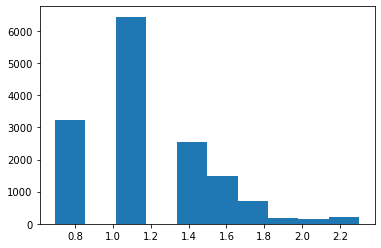

In [54]:
plt.hist(np.log(turnover['time_spend_company']))
plt.show()

In [49]:
transformed_time_spend = boxcox(turnover['time_spend_company'])
transformed_time_spend

(array([0.8046512 , 1.09811782, 0.94138084, ..., 0.8046512 , 0.94138084,
        0.8046512 ]),
 -0.5996927965683289)

In [26]:
turnover['sales'].value_counts() / turnover.shape[0]

0    0.723982
1    0.276018
Name: sales, dtype: float64

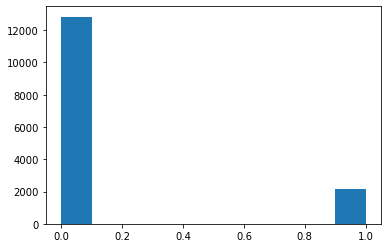

In [35]:
plt.hist(turnover['Work_accident'])
plt.show()

In [4]:
## Frequency table of left
turnover['left'].value_counts() / turnover.shape[0]

0    0.761917
1    0.238083
Name: left, dtype: float64

In [6]:
turnover['sales'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

In [7]:
turnover['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64